In [1]:
%config InlineBackend.figure_format ='retina'
%config Completer.use_jedi = False
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from typing import List, Dict, NoReturn
from io import BytesIO, StringIO
from zipfile import ZipFile
from urllib.request import urlopen

import os
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 10)

import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
# sns.set_style('darkgrid')
# sns.set_color_codes("muted")

COLLECTION = 2018

def get_filename(file_list: List[str]) -> str:
    match = [s for s in file_list if "_rv" in s]
    answer = file_list[0]
    if len(match) > 0:
        answer = match[0]
    return answer


def net_load_data(url: str, types: Dict[str, type]=None) -> pd.DataFrame:
    with urlopen(url) as resp:
        zipfile = ZipFile(BytesIO(resp.read()))
        file_name = get_filename(zipfile.namelist())
        data_file = zipfile.open(file_name)
        answer = pd.read_csv(data_file,
                             low_memory=False,
                             dtype='object',
                             encoding="iso-8859-1")

    # clean up errant whitespace in column names
    answer.columns = [colname.strip() for colname in list(answer.columns.values)]

    if types:
        for col, col_type in types.items():
            answer[col] = answer[col].astype(col_type)

    answer.columns = [x.lower() for x in answer.columns]
    return answer

def load_institutions(year: int) -> pd.DataFrame:
    URL_STUB = r'https://nces.ed.gov/ipeds/datacenter/data/'
    df = net_load_data(
    url=f"{URL_STUB}HD{year}.zip",
    types={'UNITID': np.int32,
           'FIPS': np.int32,
           'C18BASIC': np.int32,
           'CONTROL': np.int32})
    return df

def load_residency(year: int) -> pd.DataFrame:
    URL_STUB = r'https://nces.ed.gov/ipeds/datacenter/data/'
    df = net_load_data(
        url=f"{URL_STUB}EF{year}C.zip",
        types={'UNITID': np.int32,
               'EFCSTATE': np.int32,
               'LINE': np.int32,
               'EFRES01': np.float32,
               'EFRES02': np.float32})
    return df


In [2]:
if not os.path.exists('data'):
    os.mkdir('data')

if not os.path.isfile(f'data/institutions_{COLLECTION}.pkl'):
    institutions = load_institutions(COLLECTION)
    pd.to_pickle(institutions,
                 f'data/institutions_{COLLECTION}.pkl',
                 compression='zip')    
else:
    institutions = pd.read_pickle(f'data/institutions_{COLLECTION}.pkl',
                                  compression='zip')

if not os.path.isfile(f'data/residency_{COLLECTION}.pkl'):
    residency = load_residency(COLLECTION)
    pd.to_pickle(residency,
                 f'data/residency_{COLLECTION}.pkl',
                 compression='zip')    
else:
    residency = pd.read_pickle(f'data/residency_{COLLECTION}.pkl',
                               compression='zip')

In [3]:
publics = (institutions
           .query('fips < 57')
           .query('c18basic in [15, 16]')
           .query('control == 1')
           .rename({'instnm': 'institution_name',
                    'stabbr': 'state',
                    'c18basic': 'carnegie_code'},
                   axis=1)
           .filter(['unitid',
                    'institution_name',
                    'fips',
                    'state',
                    'carnegie_code'],
                  axis=1)
           .copy()
          )
publics

,unitid,institution_name,fips,state,carnegie_code
1,100663,University of Alabama at Birmingham,1,AL,15
3,100706,University of Alabama in Huntsville,1,AL,16
6,100751,The University of Alabama,1,AL,15
10,100858,Auburn University,1,AL,15
51,102094,University of South Alabama,1,AL,16
...,...,...,...,...,...
4006,243780,Purdue University-Main Campus,18,IN,15
5119,445188,University of California-Merced,6,CA,16
5280,448886,Arizona State University-Downtown Phoenix,4,AZ,16
6259,483124,Arizona State University-Skysong,4,AZ,16


In [4]:
classes = {15: "Doctoral Universities: Very High Research Activity",
           16: "Doctoral Universities: High Research Activity",
           17: "Doctoral/Professional Universities"}
publics['carnegie_class'] = publics.carnegie_code.replace(classes)
publics

,unitid,institution_name,fips,state,carnegie_code,carnegie_class
1,100663,University of Alabama at Birmingham,1,AL,15,Doctoral Universities: Very High Research Acti...
3,100706,University of Alabama in Huntsville,1,AL,16,Doctoral Universities: High Research Activity
6,100751,The University of Alabama,1,AL,15,Doctoral Universities: Very High Research Acti...
10,100858,Auburn University,1,AL,15,Doctoral Universities: Very High Research Acti...
51,102094,University of South Alabama,1,AL,16,Doctoral Universities: High Research Activity
...,...,...,...,...,...,...
4006,243780,Purdue University-Main Campus,18,IN,15,Doctoral Universities: Very High Research Acti...
5119,445188,University of California-Merced,6,CA,16,Doctoral Universities: High Research Activity
5280,448886,Arizona State University-Downtown Phoenix,4,AZ,16,Doctoral Universities: High Research Activity
6259,483124,Arizona State University-Skysong,4,AZ,16,Doctoral Universities: High Research Activity


In [5]:
states = (institutions[['fips', 'stabbr']]
          .query('fips < 57')
          .drop_duplicates()
          .set_index('fips')
          .to_dict('dict')['stabbr']
         )
len(states)

51

In [6]:
residency.fillna(0, inplace=True)
domestic = residency.query('efcstate < 57').copy()
domestic['other'] = residency.efres01 - residency.efres02
us_enroll = (domestic
             .rename({'efcstate': 'origin_fips',
                      'efres02': 'recent_hs_grad'},
                     axis=1)
             .melt(id_vars=['unitid', 'origin_fips'],
                   value_vars=['recent_hs_grad', 'other'],
                   value_name='headcount',
                   var_name='student_type')
             .copy()
            )
us_enroll['origin'] = us_enroll.origin_fips.map(states, na_action='ignore')
us_enroll

,unitid,origin_fips,student_type,headcount,origin
0,100654,1,recent_hs_grad,497.0,AL
1,100654,4,recent_hs_grad,1.0,AZ
2,100654,6,recent_hs_grad,12.0,CA
3,100654,8,recent_hs_grad,3.0,CO
4,100654,11,recent_hs_grad,3.0,DC
...,...,...,...,...,...
107319,493150,47,other,3.0,TN
107320,493318,6,other,19.0,CA
107321,493372,35,other,1.0,NM
107322,493424,26,other,20.0,MI


In [7]:
state_enrollment = publics.merge(us_enroll,
                                 how='inner',
                                 on='unitid')
state_enrollment['resident'] = np.where(state_enrollment.fips == state_enrollment.origin_fips,
                                        state_enrollment.headcount,
                                        0)
state_enrollment

,unitid,institution_name,fips,state,carnegie_code,carnegie_class,origin_fips,student_type,headcount,origin,resident
0,100663,University of Alabama at Birmingham,1,AL,15,Doctoral Universities: Very High Research Acti...,1,recent_hs_grad,1904.0,AL,1904.0
1,100663,University of Alabama at Birmingham,1,AL,15,Doctoral Universities: Very High Research Acti...,2,recent_hs_grad,0.0,AK,0.0
2,100663,University of Alabama at Birmingham,1,AL,15,Doctoral Universities: Very High Research Acti...,4,recent_hs_grad,3.0,AZ,0.0
3,100663,University of Alabama at Birmingham,1,AL,15,Doctoral Universities: Very High Research Acti...,6,recent_hs_grad,8.0,CA,0.0
4,100663,University of Alabama at Birmingham,1,AL,15,Doctoral Universities: Very High Research Acti...,8,recent_hs_grad,3.0,CO,0.0
...,...,...,...,...,...,...,...,...,...,...,...
12721,486840,Kennesaw State University,13,GA,16,Doctoral Universities: High Research Activity,49,other,2.0,UT,0.0
12722,486840,Kennesaw State University,13,GA,16,Doctoral Universities: High Research Activity,51,other,1.0,VA,0.0
12723,486840,Kennesaw State University,13,GA,16,Doctoral Universities: High Research Activity,53,other,0.0,WA,0.0
12724,486840,Kennesaw State University,13,GA,16,Doctoral Universities: High Research Activity,54,other,0.0,WV,0.0


In [8]:
in_state = (state_enrollment[['unitid',
                              'resident',
                              'headcount']]
            .groupby('unitid')
            .sum()
            .reset_index()
           )
in_state['in_state'] = in_state.resident / in_state.headcount
in_state

,unitid,resident,headcount,in_state
0,100663,1917.0,2269.0,0.844866
1,100706,913.0,1390.0,0.656835
2,100751,2271.0,6529.0,0.347833
3,100858,2756.0,4735.0,0.582049
4,102094,1491.0,1895.0,0.786807
...,...,...,...,...
177,243780,4391.0,7548.0,0.581743
178,445188,2207.0,2212.0,0.997740
179,448886,898.0,1404.0,0.639601
180,483124,847.0,2363.0,0.358443


In [9]:
recent_hs = (domestic[['unitid',
                         'efres01',
                         'efres02']]
               .groupby('unitid')
               .sum()
               .reset_index()
              )
recent_hs['traditional'] = recent_hs.efres02 / recent_hs.efres01
recent_hs

,unitid,efres01,efres02,traditional
0,100654,1383.0,1043.0,0.754158
1,100663,2269.0,2254.0,0.993389
2,100690,1.0,0.0,0.000000
3,100706,1390.0,1269.0,0.912950
4,100724,1024.0,302.0,0.294922
...,...,...,...,...
5663,493150,10.0,7.0,0.700000
5664,493318,19.0,0.0,0.000000
5665,493372,1.0,0.0,0.000000
5666,493424,20.0,0.0,0.000000


In [10]:
metrics = (publics
           .merge(recent_hs[['unitid', 'traditional']],
                  how='inner',
                  on='unitid')
           .merge(in_state[['unitid', 'in_state']],
                  how='inner',
                  on='unitid')
          )
metrics

,unitid,institution_name,fips,state,carnegie_code,carnegie_class,traditional,in_state
0,100663,University of Alabama at Birmingham,1,AL,15,Doctoral Universities: Very High Research Acti...,0.993389,0.844866
1,100706,University of Alabama in Huntsville,1,AL,16,Doctoral Universities: High Research Activity,0.912950,0.656835
2,100751,The University of Alabama,1,AL,15,Doctoral Universities: Very High Research Acti...,0.997243,0.347833
3,100858,Auburn University,1,AL,15,Doctoral Universities: Very High Research Acti...,0.980993,0.582049
4,102094,University of South Alabama,1,AL,16,Doctoral Universities: High Research Activity,0.959894,0.786807
...,...,...,...,...,...,...,...,...
177,243780,Purdue University-Main Campus,18,IN,15,Doctoral Universities: Very High Research Acti...,0.987811,0.581743
178,445188,University of California-Merced,6,CA,16,Doctoral Universities: High Research Activity,0.997288,0.997740
179,448886,Arizona State University-Downtown Phoenix,4,AZ,16,Doctoral Universities: High Research Activity,0.977920,0.639601
180,483124,Arizona State University-Skysong,4,AZ,16,Doctoral Universities: High Research Activity,0.511215,0.358443


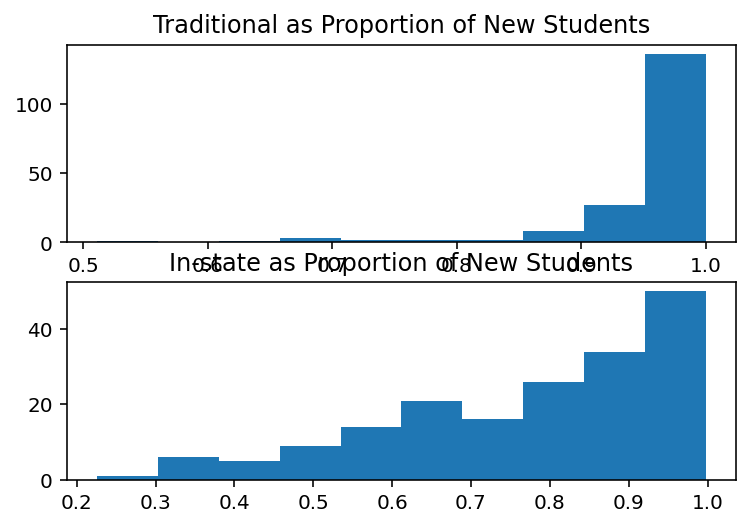

In [21]:
fig, ax = plt.subplots(2, 1)
_ = ax[0].hist(metrics.traditional)
_ = ax[0].set_title('Traditional as Proportion of New Students')
_ = ax[1].hist(metrics.in_state)
_ = ax[1].set_title('In-state as Proportion of New Students')
plt.show()

In [12]:
metrics.traditional.min()

0.511214554309845

In [13]:
metrics.in_state.min()

0.22593636810779572

In [14]:
metrics[metrics.traditional < 0.6]

,unitid,institution_name,fips,state,carnegie_code,carnegie_class,traditional,in_state
180,483124,Arizona State University-Skysong,4,AZ,16,Doctoral Universities: High Research Activity,0.511215,0.358443


In [22]:
metrics[metrics.unitid == 181464]

,unitid,institution_name,fips,state,carnegie_code,carnegie_class,traditional,in_state
92,181464,University of Nebraska-Lincoln,31,NE,15,Doctoral Universities: Very High Research Acti...,0.97554,0.736668


In [15]:
metrics.traditional.median()
metrics.in_state.median()

0.9725335836410522

0.819328784942627

Text(0.5, 0, 'Traditional New Students')

Text(0, 0.5, 'In-state Enrollment')

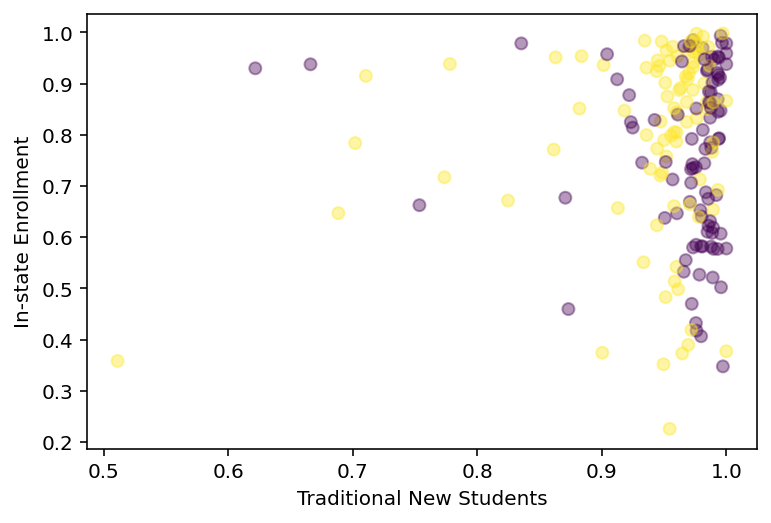

In [16]:
fix, ax = plt.subplots()
ax.scatter(metrics.traditional,
           metrics.in_state,
           c=metrics.carnegie_code,
           alpha=2/5)
ax.set_xlabel('Traditional New Students')
ax.set_ylabel('In-state Enrollment')
plt.show()